---
* **Universidad:** UOC (Universitat Oberta de Catalunya)
* **Titulación:** Master Ciencia de Datos/TFM
* **Título:** Segmentación de imágenes utilizando Redes Generativas Antagónicas
* **Actividad**: Creación Data Set Imagenes
* **Autor:** Miguel Ponce
* **Correo:** miguelalejoponce@uoc.edu
* **Fecha:** "Enero, 05 de 2023"
* **Salida**: ipynb
---
## Contexto: Detección de personas

* **Contexto:**
Se desea crea un nuevo conjunto de datos que será utilizado por la red GAN.

* **Problema:** 
Es necesrio realizar tareas de analis estadistico sobre el resulta de la imagenes medianas Medianas y HD
* **Solucion :** 
Se utilizara herramietas como pandas y visualizacion para establecer cuales serán las medidas estandar de la imagenes en largo y ancho que luego serán cargadas en la herramienta Roboflow.
* **Entorno:** sin GPU.
  

## Origen del la fuente de datos
* **
YouTube-GDD:** https://github.com/UCAS-GYX/YouTube-GDD

@article{gu2022youtube-gdd,
  title={YouTube-GDD: A challenging gun detection dataset with rich contextual information},
  author={Gu Yongxiang and Liao Xingbin and Qin Xiaolin},
  journal={arXiv preprint arXiv:2203.04129},
  year={2022}
}

## Descarga conjunto de datos

In [ ]:
!wget https://raw.githubusercontent.com/miguelalejo/gan-segmentation-person-gun/main/data/raw/segmented-body-parts-gun/segmented-body-parts-gun-rdn-YouTube-GDD.tar.gz -O segmented-body-parts-gun-rdn-YouTube-GDD.tar.gz

--2023-01-09 23:58:14--  https://raw.githubusercontent.com/miguelalejo/gan-segmentation-person-gun/main/data/raw/segmented-body-parts-gun/segmented-body-parts-gun-rdn-YouTube-GDD.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57003589 (54M) [application/octet-stream]
Saving to: ‘segmented-body-parts-gun-rdn-YouTube-GDD.tar.gz’

segmented-body-part 100%[===================>]  54.36M   156MB/s    in 0.3s    

2023-01-09 23:58:15 (156 MB/s) - ‘segmented-body-parts-gun-rdn-YouTube-GDD.tar.gz’ saved [57003589/57003589]



In [ ]:
!tar -xvf segmented-body-parts-gun-rdn-YouTube-GDD.tar.gz

./segmented-body-parts-gun-rdn/
./segmented-body-parts-gun-rdn/segmentado/
./segmented-body-parts-gun-rdn/segmentado/r31q0MOpWZ0_30_60_000230.jpg
./segmented-body-parts-gun-rdn/segmentado/dzzNEEsYjL0&t=2s_30_60_000067.jpg
./segmented-body-parts-gun-rdn/segmentado/n-O5mnscPQE_24_48_000219.jpg
./segmented-body-parts-gun-rdn/segmentado/rQSM6heU-p4&t=28s_30_60_000267.jpg
./segmented-body-parts-gun-rdn/segmentado/aid5YDI1ZSc_25_50_000010.jpg
./segmented-body-parts-gun-rdn/segmentado/A2vf4KuKepk_24_48_000055.jpg
./segmented-body-parts-gun-rdn/segmentado/ak-QH9x8Hcc_24_48_000016.jpg
./segmented-body-parts-gun-rdn/segmentado/BzNm3R2Qvhk_25_50_000237.jpg
./segmented-body-parts-gun-rdn/segmentado/tY1cP0Rnc2k_30_60_000017.jpg
./segmented-body-parts-gun-rdn/segmentado/FPsIx8GmKxg_30_60_000475.jpg
./segmented-body-parts-gun-rdn/segmentado/zgYkgq3NzzQ_25_50_000011.jpg
./segmented-body-parts-gun-rdn/segmentado/vVRPGSz7XXU&t=56s_30_60_000021.jpg
./segmented-body-parts-gun-rdn/segmentado/vpIEN4RhLmU_30

## Liberías

In [ ]:
import PIL
import os
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
from numpy import asarray
import cv2
import matplotlib.image as mpimg
from matplotlib import pyplot as pltç
from pathlib import Path
import os
import glob

## Constantes

In [ ]:
SEMILLA_ALEATORIA = 1234

## Clases

In [ ]:
class ImageEvaluatorUtil:
  def __init__(self,sourcePath,sourceBitMaskPath,sourceBitMaskGunPath) -> None:    
    self.sourcePath = sourcePath
    self.sourceBitMaskPath = sourceBitMaskPath
    self.sourceBitMaskGunPath = sourceBitMaskGunPath
    self.columnsSize = ['widths', 'heights']
    self.columnsRatios = ['bitMaskRatio','bitMaskGunRatio']
    self.columns = self.columnsSize+self.columnsRatios
    self.allcolumns = ['nameFile'] + self.columns
    self.dataFrame = self.createDataFrame()
    
  def count_nonblack_pil(self,img):
    """Return the number of pixels in img that are not black.
    img must be a PIL.Image object in mode RGB.

    """
    bbox = img.getbbox()
    if not bbox: return 0
    return sum(img.crop(bbox)
               .point(lambda x: 255 if x else 0)
               .convert("L")
               .point(bool)
               .getdata())
    
  def calculateRatio(self,imageName,sourcePath):
    imageNamePng = Path(imageName).stem+'.png'
    imagePngPath = os.path.join(sourcePath,imageNamePng)
    #im = Image.open(imagePngPath)

    #width, height = im.size
    #white = self.count_nonblack_pil(im)

    
    #img = cv2.imread(imagePngPath, cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(imagePngPath, cv2.IMREAD_UNCHANGED)
    
    n_white_pix = np.sum(img == 255)
    n_back_pix = np.sum(img == 0)
    return n_white_pix/(n_back_pix+n_white_pix)

  def createDataFrame(self):
    path = self.sourcePath+"/*.jpg"    
    images = glob.glob(path)
    listNames = []    
    widths = []
    heights = []
    imageName = []
    bitMaskRatios = []
    bitMaskGunRatios = []
    for imagePath in images:              
        im = Image.open(imagePath)
        widths.append(im.size[0])
        heights.append(im.size[1])
        imageName = os.path.basename(imagePath)         
        listNames.append(Path(imageName).stem)                            
        bitMaskRatio = self.calculateRatio(imageName,self.sourceBitMaskPath)
        bitMaskGunRatio = self.calculateRatio(imageName,self.sourceBitMaskGunPath)
        bitMaskRatios.append(bitMaskRatio)
        bitMaskGunRatios.append(bitMaskGunRatio)
    return pd.DataFrame(list(zip(listNames,widths,heights,bitMaskRatios,bitMaskGunRatios)),
               columns =self.allcolumns)
  
    
  def plotDataFrame(self,dataFrame):
    a4_dims = (8, 5)    
    fig, ax = plt.subplots(1,2,figsize=a4_dims)
    sns.violinplot(data=dataFrame[self.columnsSize],ax=ax[0])
    sns.boxplot(data=dataFrame[self.columnsSize], ax=ax[1])        
    plt.show()  

  def plotDataFrameBinMaskRatio(self,dataFrame):
    fig, ax = plt.subplots(1,2)
    sns.violinplot(data=dataFrame[self.columnsRatios],ax=ax[0])
    sns.boxplot(data=dataFrame[self.columnsRatios], ax=ax[1])        
    plt.show() 

  def graficarImagenes(self,listImages,sourcePath,format):    
    # create figure
    fig = plt.figure(figsize=(20, 10))
    # setting values to rows and column variables
    rows = 2
    columns = 10    
    # reading images
    for i in range(1,rows*columns+1):
      imageName = listImages[i-1]+"."+format
      imagePath =  os.path.join(sourcePath,imageName)        
      fig.add_subplot(rows, columns, i)
      image = mpimg.imread(imagePath)      
      plt.imshow(image, cmap='gray')
      plt.axis('off')
      plt.title(f"ID:{i}")

  def graficarImagenesAletorias(self,dataFrame,sourcePath,sourceBitMaskPath):
    dataFrameRandom = dataFrame.sample(n=20, random_state=SEMILLA_ALEATORIA)
    listNames = dataFrameRandom['nameFile'].values.tolist()
    self.graficarImagenes(listNames,sourceBitMaskPath,"png")
    self.graficarImagenes(listNames,sourcePath,"jpg")
  

  def eilminarOutliers(self):
    data = self.dataFrame.copy()      
    Q1 = data[self.columns].quantile(0.25)
    Q3 = data[self.columns].quantile(0.75)
    IQR = Q3 - Q1      
    data[self.columns] = data[self.columns][~((data[self.columns] < (Q1 - 1.5 * IQR)) |(data[self.columns] > (Q3 + 1.5 * IQR))).any(axis=1)]
    return data 

# Evaluación Imágenes Grandes RDN

## Visualizar Outliers

In [ ]:
pathSource = "segmented-body-parts-gun-rdn/original"
pathBinMask = "segmented-body-parts-gun-rdn/mascara"
pathBinMaskGun = "segmented-body-parts-gun-rdn/guns-detection-rdn/binmask"
imageEvaluatorUtilRDN = ImageEvaluatorUtil(pathSource,pathBinMask,pathBinMaskGun)

## Validar lecutra

In [ ]:
imageEvaluatorUtilRDN.dataFrame.isnull().sum().sum()

0

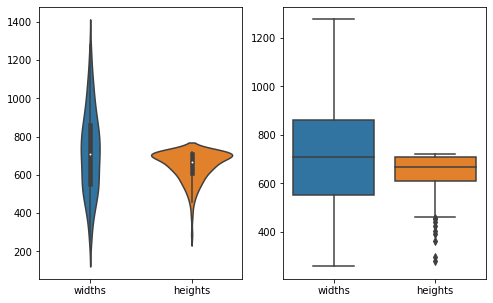

In [ ]:
imageEvaluatorUtilRDN.plotDataFrame(imageEvaluatorUtilRDN.dataFrame)

## Descripción Conjunto Datos Original

In [ ]:
imageEvaluatorUtilRDN.dataFrame.describe()

,widths,heights,bitMaskRatio,bitMaskGunRatio
count,324.000000,324.00000,324.000000,324.000000
mean,719.151235,647.12037,0.478223,0.592012
std,216.240532,78.01350,0.094563,0.135256
min,257.000000,279.00000,0.272548,0.219438
25%,552.500000,608.00000,0.420843,0.489019
50%,708.500000,669.00000,0.466104,0.607021
75%,861.250000,709.00000,0.530055,0.686412
max,1277.000000,720.00000,0.932664,0.877350


## Eliminar outliers

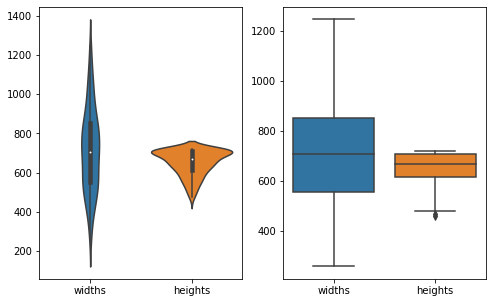

In [ ]:
dataFrameNuevoRDN = imageEvaluatorUtilRDN.eilminarOutliers()
dataFrameNuevoRDN.dropna(inplace=True)
imageEvaluatorUtilRDN.plotDataFrame(dataFrameNuevoRDN)

## Graficar relación al aspecto

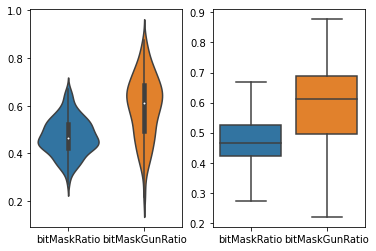

In [ ]:
imageEvaluatorUtilRDN.plotDataFrameBinMaskRatio(dataFrameNuevoRDN)

## Mostrar estadisticas

In [ ]:
dataFrameNuevoRDN.describe()

,widths,heights,bitMaskRatio,bitMaskGunRatio
count,305.000000,305.000000,305.000000,305.000000
mean,716.127869,652.537705,0.470393,0.595247
std,212.047196,64.934325,0.077726,0.133970
min,257.000000,460.000000,0.272548,0.219438
25%,553.000000,615.000000,0.421546,0.495715
50%,707.000000,669.000000,0.465416,0.612663
75%,853.000000,708.000000,0.524418,0.687331
max,1246.000000,720.000000,0.668752,0.877350


## No es necesario aplicar filtro

In [ ]:
dataFrameNuevoRDN['maskValid'] = dataFrameNuevoRDN.apply (lambda row: row['bitMaskGunRatio']<=100, axis=1)

## Mostramos las estadisticas con el conjunto de datos tratado

In [ ]:
dataFrameCleanRDN = dataFrameNuevoRDN[dataFrameNuevoRDN['maskValid']==True] 
dataFrameCleanRDN.describe()

,widths,heights,bitMaskRatio,bitMaskGunRatio
count,305.000000,305.000000,305.000000,305.000000
mean,716.127869,652.537705,0.470393,0.595247
std,212.047196,64.934325,0.077726,0.133970
min,257.000000,460.000000,0.272548,0.219438
25%,553.000000,615.000000,0.421546,0.495715
50%,707.000000,669.000000,0.465416,0.612663
75%,853.000000,708.000000,0.524418,0.687331
max,1246.000000,720.000000,0.668752,0.877350


## Realizamos una exploración visual

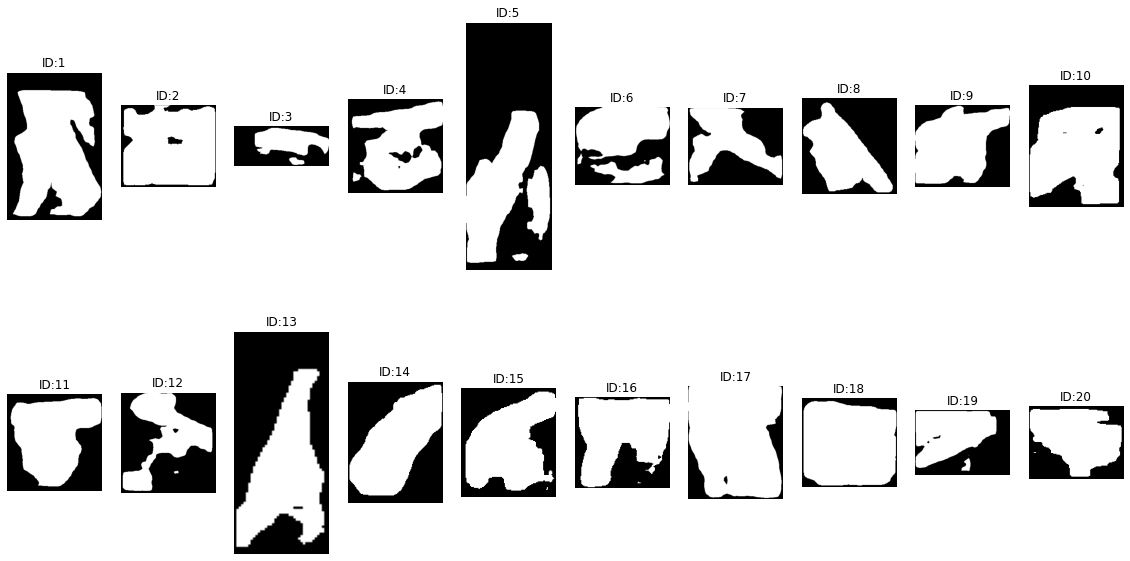

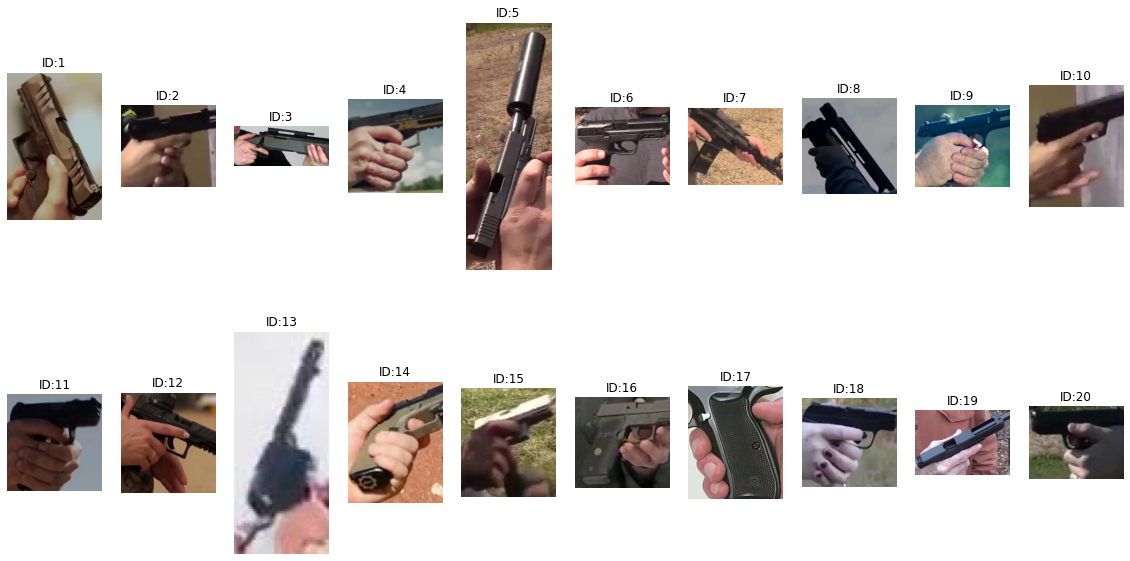

In [ ]:
pathOriginal ="segmented-body-parts-gun-rdn/guns-detection-rdn/crops"
pathBinMask= "segmented-body-parts-gun-rdn/guns-detection-rdn/binmask"
imageEvaluatorUtilRDN.graficarImagenesAletorias(dataFrameCleanRDN,pathOriginal,pathBinMask)

## Mostrar Conjunto de Datos Resultados

In [ ]:
dataFrameCleanRDN

,nameFile,widths,heights,bitMaskRatio,bitMaskGunRatio,maskValid
0,GDWKRdJOtV0_30_60_000245,860.0,672.0,0.495447,0.622863,True
1,tPNS4vUlX60_30_60_000363,463.0,478.0,0.442786,0.721476,True
2,J0Qd7ghAWYw_30_60_000001,669.0,644.0,0.478343,0.463662,True
3,GDWKRdJOtV0_30_60_000235,853.0,720.0,0.556459,0.432692,True
4,1uylLbpSe9M_30_60_000175,722.0,679.0,0.361933,0.621717,True
...,...,...,...,...,...,...
319,A3F1QvCHQLQ_30_60_000289,978.0,701.0,0.387145,0.709349,True
320,GDWKRdJOtV0_30_60_0002712,471.0,512.0,0.432950,0.779617,True
321,7H9RtvLyATs_30_60_000296,489.0,520.0,0.460679,0.472696,True
322,A3F1QvCHQLQ_30_60_000115,958.0,648.0,0.473319,0.649463,True


In [ ]:
dataFrameCleanRDN.describe()

,widths,heights,bitMaskRatio,bitMaskGunRatio
count,305.000000,305.000000,305.000000,305.000000
mean,716.127869,652.537705,0.470393,0.595247
std,212.047196,64.934325,0.077726,0.133970
min,257.000000,460.000000,0.272548,0.219438
25%,553.000000,615.000000,0.421546,0.495715
50%,707.000000,669.000000,0.465416,0.612663
75%,853.000000,708.000000,0.524418,0.687331
max,1246.000000,720.000000,0.668752,0.877350


## Conlusión

**Luego de revisar las estadisticas para cada conjunto de datos decidimos tomar el data set RDN(imagenes grandes) y definir como estandar de medida de las imágenes 410 ancho y largo	824. En donde se tomáran únicamente aquellas imagenes cuya segementación del arma se encuentre bajo el 3er inter queartil.** 

# Creación conjunto de data set

## Creacion proyecto armas cortas 

In [ ]:
!rm -rf data-set-person-armed 
!mkdir data-set-person-armed

## Clases

In [ ]:
class MergeImages:
  def __init__(self,dataSetImages,sourcePathOrignal, formatOriginal, sourcePathMask, formatMask,outputPath) -> None:    
    self.sourcePathOrignal = sourcePathOrignal
    self.sourcePathMask = sourcePathMask
    self.outputPath = outputPath  
    self.dataSetImages = dataSetImages
    self.formatOriginal = formatOriginal
    self.formatMask = formatMask

  def mergeImages(self,pathImageMask,pathImageReal,name):
    images = [Image.open(x) for x in [pathImageMask, pathImageReal]]
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    new_im = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    for im in images:
      new_im.paste(im, (x_offset,0))
      x_offset += im.size[0]    
    filePath = os.path.join(self.outputPath,name+"."+self.formatOriginal)
    new_im.save(filePath)
    print("Saved merge image as %s" % filePath)

  def processImages(self):        
    for name in self.dataSetImages['nameFile'].values:
      pathImageMask = os.path.join(self.sourcePathMask,name+"."+self.formatMask)      
      pathImageOrignal = os.path.join(self.sourcePathOrignal,name+"."+self.formatOriginal)
      self.mergeImages(pathImageMask,pathImageOrignal,name)     
      
      

## Pipeline creacion data set

In [ ]:
dataSetImages = dataFrameCleanRDN
pathOriginal ="segmented-body-parts-gun-rdn/original"
pathColoredMask= "segmented-body-parts-gun-rdn/segmentado"
outputPathMergeImages = "data-set-person-armed"
mergeImages = MergeImages(dataFrameCleanRDN,pathOriginal,"jpg",pathColoredMask,"jpg",outputPathMergeImages)

In [ ]:
mergeImages.processImages()

Saved merge image as data-set-person-armed/GDWKRdJOtV0_30_60_000245.jpg
Saved merge image as data-set-person-armed/tPNS4vUlX60_30_60_000363.jpg
Saved merge image as data-set-person-armed/J0Qd7ghAWYw_30_60_000001.jpg
Saved merge image as data-set-person-armed/GDWKRdJOtV0_30_60_000235.jpg
Saved merge image as data-set-person-armed/1uylLbpSe9M_30_60_000175.jpg
Saved merge image as data-set-person-armed/2FiBkfmUZR4_30_60_000004.jpg
Saved merge image as data-set-person-armed/QW5oYlmc5-g_25_50_000157.jpg
Saved merge image as data-set-person-armed/IV0TpHM3TOU&t=1s_30_60_000115.jpg
Saved merge image as data-set-person-armed/dzzNEEsYjL0&t=2s_30_60_000067.jpg
Saved merge image as data-set-person-armed/gYtovSp6ytc_30_60_000169.jpg
Saved merge image as data-set-person-armed/NU539JwyHZ8_24_48_000179.jpg
Saved merge image as data-set-person-armed/tLxnNP-ycVQ_25_50_000173.jpg
Saved merge image as data-set-person-armed/xp1obnNeO34_24_48_000167.jpg
Saved merge image as data-set-person-armed/A3F1QvCHQLQ

In [ ]:
!tar -czvf data-set-person-armed-YouTube-GDD.tar.gz "data-set-person-armed"

data-set-person-armed/
data-set-person-armed/GDWKRdJOtV0_30_60_000245.jpg
data-set-person-armed/tPNS4vUlX60_30_60_000363.jpg
data-set-person-armed/J0Qd7ghAWYw_30_60_000001.jpg
data-set-person-armed/GDWKRdJOtV0_30_60_000235.jpg
data-set-person-armed/1uylLbpSe9M_30_60_000175.jpg
data-set-person-armed/2FiBkfmUZR4_30_60_000004.jpg
data-set-person-armed/QW5oYlmc5-g_25_50_000157.jpg
data-set-person-armed/IV0TpHM3TOU&t=1s_30_60_000115.jpg
data-set-person-armed/dzzNEEsYjL0&t=2s_30_60_000067.jpg
data-set-person-armed/gYtovSp6ytc_30_60_000169.jpg
data-set-person-armed/NU539JwyHZ8_24_48_000179.jpg
data-set-person-armed/tLxnNP-ycVQ_25_50_000173.jpg
data-set-person-armed/xp1obnNeO34_24_48_000167.jpg
data-set-person-armed/A3F1QvCHQLQ_30_60_000264.jpg
data-set-person-armed/IV0TpHM3TOU&t=1s_30_60_000217.jpg
data-set-person-armed/Nwb1qVeLmVc_30_60_000236.jpg
data-set-person-armed/GDWKRdJOtV0_30_60_000026.jpg
data-set-person-armed/ByPQ3YIfX5Q_30_60_000088.jpg
data-set-person-armed/tLxnNP-ycVQ_25_50_0001

## Creacion proyecto armas cortas mascara de bits

In [ ]:
!rm -rf data-set-person-armed-bitmask
!mkdir data-set-person-armed-bitmask

## Pipeline creacion data set

In [ ]:
dataSetImages = dataFrameCleanRDN
pathOriginal ="segmented-body-parts-gun-rdn/original"
pathBitMask= "segmented-body-parts-gun-rdn/mascara"
outputPathMergeImages = "data-set-person-armed-bitmask"
mergeImages = MergeImages(dataFrameCleanRDN,pathOriginal,"jpg",pathBitMask,"png",outputPathMergeImages)

In [ ]:
mergeImages.processImages()

Saved merge image as data-set-person-armed-bitmask/GDWKRdJOtV0_30_60_000245.jpg
Saved merge image as data-set-person-armed-bitmask/tPNS4vUlX60_30_60_000363.jpg
Saved merge image as data-set-person-armed-bitmask/J0Qd7ghAWYw_30_60_000001.jpg
Saved merge image as data-set-person-armed-bitmask/GDWKRdJOtV0_30_60_000235.jpg
Saved merge image as data-set-person-armed-bitmask/1uylLbpSe9M_30_60_000175.jpg
Saved merge image as data-set-person-armed-bitmask/2FiBkfmUZR4_30_60_000004.jpg
Saved merge image as data-set-person-armed-bitmask/QW5oYlmc5-g_25_50_000157.jpg
Saved merge image as data-set-person-armed-bitmask/IV0TpHM3TOU&t=1s_30_60_000115.jpg
Saved merge image as data-set-person-armed-bitmask/dzzNEEsYjL0&t=2s_30_60_000067.jpg
Saved merge image as data-set-person-armed-bitmask/gYtovSp6ytc_30_60_000169.jpg
Saved merge image as data-set-person-armed-bitmask/NU539JwyHZ8_24_48_000179.jpg
Saved merge image as data-set-person-armed-bitmask/tLxnNP-ycVQ_25_50_000173.jpg
Saved merge image as data-set-

In [ ]:
!tar -czvf data-set-person-armed-bitmask-YouTube-GDD.tar.gz "data-set-person-armed-bitmask"

data-set-person-armed-bitmask/
data-set-person-armed-bitmask/GDWKRdJOtV0_30_60_000245.jpg
data-set-person-armed-bitmask/tPNS4vUlX60_30_60_000363.jpg
data-set-person-armed-bitmask/J0Qd7ghAWYw_30_60_000001.jpg
data-set-person-armed-bitmask/GDWKRdJOtV0_30_60_000235.jpg
data-set-person-armed-bitmask/1uylLbpSe9M_30_60_000175.jpg
data-set-person-armed-bitmask/2FiBkfmUZR4_30_60_000004.jpg
data-set-person-armed-bitmask/QW5oYlmc5-g_25_50_000157.jpg
data-set-person-armed-bitmask/IV0TpHM3TOU&t=1s_30_60_000115.jpg
data-set-person-armed-bitmask/dzzNEEsYjL0&t=2s_30_60_000067.jpg
data-set-person-armed-bitmask/gYtovSp6ytc_30_60_000169.jpg
data-set-person-armed-bitmask/NU539JwyHZ8_24_48_000179.jpg
data-set-person-armed-bitmask/tLxnNP-ycVQ_25_50_000173.jpg
data-set-person-armed-bitmask/xp1obnNeO34_24_48_000167.jpg
data-set-person-armed-bitmask/A3F1QvCHQLQ_30_60_000264.jpg
data-set-person-armed-bitmask/IV0TpHM3TOU&t=1s_30_60_000217.jpg
data-set-person-armed-bitmask/Nwb1qVeLmVc_30_60_000236.jpg
data-set-p

## Montar Drive

In [ ]:
import os
from google.colab import drive
ROOT_FOLDER='/content/'
ROOT_DRIVE_FOLDER=ROOT_FOLDER+'drive/'
drive.mount(ROOT_DRIVE_FOLDER)

Mounted at /content/drive/


In [ ]:
!cp --suffix=_v_$(date +"%y-%m-%d--%T")  ./data-set-person-armed-YouTube-GDD.tar.gz /content/drive/MyDrive/tmf-person-data/data_set_processed/merge-dataset

In [ ]:
!cp --suffix=_v_$(date +"%y-%m-%d--%T")  ./data-set-person-armed-bitmask.tar.gz /content/drive/MyDrive/tmf-person-data/data_set_processed/merge-dataset